In [ ]:
import math
import numpy as np
from functools import lru_cache

MAX_CARS = 20
MAX_MOVE = 5

A = [i for i in range(-MAX_MOVE, MAX_MOVE + 1)]
LAMBDA_RENTAL_1 = 3
LAMBDA_RENTAL_2 = 4
LAMBDA_RETURN_1 = 3
LAMBDA_RETURN_2 = 2

PROFIT_RENTAL = 10
MOVE_COST = 2

# --- Poisson helpers ---

def poisson_pmf(lam, k):
    return (lam ** k) * math.exp(-lam) / math.factorial(k)

@lru_cache(maxsize=None)
def poisson_tail_ge(lam, k):
    # P[X >= k] for Poisson(lam)
    if k <= 0:
        return 1.0
    s = 0.0
    for i in range(k):
        s += poisson_pmf(lam, i)
    return max(0.0, 1.0 - s)

# --- Precompute per-location transitions and rental revenue ---

def precompute_location(lambda_rental, lambda_return):
    size = MAX_CARS + 1
    trans = np.zeros((size, size), dtype=float)
    revenue = np.zeros(size, dtype=float)

    for n in range(size):
        # Expected rentals revenue when starting with n cars
        tail_ge_n = poisson_tail_ge(lambda_rental, n)
        revenue[n] = PROFIT_RENTAL * (
            sum(r * poisson_pmf(lambda_rental, r) for r in range(n)) + n * tail_ge_n
        )

        # Rentals: 0..n-1 exactly, then tail lump for >= n
        rental_cases = [(r, poisson_pmf(lambda_rental, r)) for r in range(n)]
        rental_cases.append((n, tail_ge_n))

        for rentals, p_r in rental_cases:
            if p_r <= 0.0:
                continue
            after_rentals = n - rentals
            free = MAX_CARS - after_rentals

            if free > 0:
                # Returns: 0..free-1 exactly, then tail lump for >= free (capped by capacity)
                for ret in range(free):
                    p_t = poisson_pmf(lambda_return, ret)
                    if p_t <= 0.0:
                        continue
                    k = after_rentals + ret
                    trans[n, k] += p_r * p_t
                tail = poisson_tail_ge(lambda_return, free)
                if tail > 0.0:
                    k = after_rentals + free  # equals MAX_CARS when free > 0
                    trans[n, k] += p_r * tail
            else:
                # No capacity left; all returns are lost that day
                trans[n, after_rentals] += p_r

        # Normalize for numerical stability
        rs = trans[n].sum()
        if rs > 0:
            trans[n] /= rs

    return trans, revenue

TRANS_1, REV_1 = precompute_location(LAMBDA_RENTAL_1, LAMBDA_RETURN_1)
TRANS_2, REV_2 = precompute_location(LAMBDA_RENTAL_2, LAMBDA_RETURN_2)

# --- MDP helpers ---

def get_action_set(s):
    return [
        a for a in A
        if 0 <= s[0] - a <= MAX_CARS
        and 0 <= s[1] + a <= MAX_CARS
    ]


def expected_value_for_action(V, s, a, gamma):
    # Apply overnight move
    n1 = s[0] - a
    n2 = s[1] + a

    # Immediate reward: expected rental revenue minus move cost
    immediate = REV_1[n1] + REV_2[n2] - MOVE_COST * abs(a)

    # Next value: E[V[k1, k2]] where k1 ~ TRANS_1[n1], k2 ~ TRANS_2[n2]
    p1 = TRANS_1[n1]
    p2 = TRANS_2[n2]
    W = V @ p2  # W[k1] = sum_k2 V[k1,k2] * P2[k2]
    return immediate + gamma * float(p1 @ W)


def policy_evaluation(V, S, pi, theta=1e-6, gamma=1.0):
    while True:
        delta = 0.0
        for s in S:
            v = V[s]
            actions = get_action_set(s)
            action = pi(s, actions)
            V[s] = expected_value_for_action(V, s, action, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


def policy_improvement(V, S, pi, gamma=1.0):
    policy_stable = True
    for s in S:
        actions = get_action_set(s)
        old_action = pi(s, actions)
        q_vals = [expected_value_for_action(V, s, a, gamma) for a in actions]
        best_action = actions[int(np.argmax(q_vals))] if actions else 0
        pi_storage[s] = best_action
        if best_action != old_action:
            policy_stable = False
    return policy_stable


def policy_iteration(S, pi, gamma=.9, theta=1e-3):
    V = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=float)
    while True:
        V = policy_evaluation(V, S, pi, theta, gamma)
        if policy_improvement(V, S, pi, gamma):
            break
    return V, pi


S = [
    (i, j)
    for i in range(MAX_CARS+1)
    for j in range(MAX_CARS+1)
]

pi_storage = {s: 0 for s in S}

def pi(s, actions):
    return pi_storage[s]

V, _ = policy_iteration(S, pi, gamma=.9, theta=1e-3)

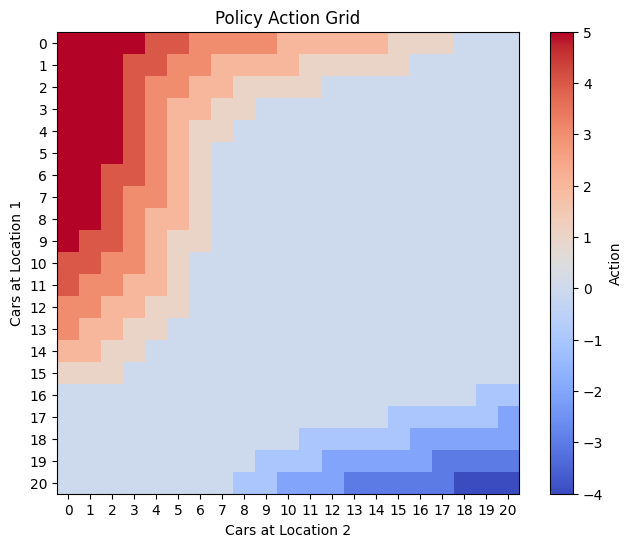

In [ ]:
import matplotlib.pyplot as plt

action_matrix = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)
for i in range(MAX_CARS + 1):
    for j in range(MAX_CARS + 1):
        action_matrix[i, j] = pi((i, j), get_action_set((i, j)))

action_matrix = action_matrix[::-1]

plt.figure(figsize=(8, 6))
plt.imshow(action_matrix, cmap='coolwarm', interpolation='nearest', origin='upper')
plt.colorbar(label='Action')
plt.title('Policy Action Grid')
plt.xlabel('Cars at Location 2')
plt.ylabel('Cars at Location 1')
plt.xticks(range(action_matrix.shape[1]))
plt.yticks(range(action_matrix.shape[0]))
plt.show()